In [1]:
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from us import states
import geopandas as gpd
from shapely import Point
from pathlib import Path
from tqdm import tqdm

sys.path.append("../functions")

from nrel_data_api import *

In [2]:
%%time
il_counties = gpd.read_file(states.IL.shapefile_urls()['county'])

CPU times: total: 297 ms
Wall time: 1.37 s


In [3]:
%%time
il_counties.to_crs(epsg=4326, inplace=True)

CPU times: total: 375 ms
Wall time: 376 ms


# Get Service Map

In [4]:
%%time
bounding_box = None
service_gdf = gpd.read_file("../../spatial-data/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp",
                            bbox=bounding_box)

c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


CPU times: total: 750 ms
Wall time: 768 ms


In [5]:
il_service = service_gdf[service_gdf['STATE']=='IL']

In [6]:
il_service = il_service.replace(dict(zip(il_service['CNTRL_AREA'].unique(), ['MISO-Z4','ComEd','EEI'])))

In [7]:
il_service['AVG_GHI'] = np.nan

In [8]:
il_service_simple = il_service.dissolve('CNTRL_AREA',as_index=False).set_index("CNTRL_AREA", drop=False).drop(labels='EEI')

In [9]:
centroids = il_service_simple.to_crs(epsg=5070).centroid.to_crs(epsg=4269)
il_service_simple = il_service_simple.assign(centroids = centroids, longitude_ctr = centroids.x, latitude_ctr = centroids.y)

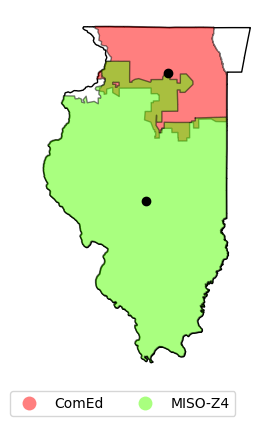

In [10]:
fig, ax = plt.subplots()
il_counties.dissolve('STATEFP10').plot(ax=ax,facecolor='w',edgecolor='k')
il_service_simple.plot(ax=ax, 
                column='CNTRL_AREA',
                categorical=True,
                cmap='prism',
                legend=True,
                legend_kwds=dict(loc=(-0.1, -0.1), ncols=3),
                alpha=0.5,
                edgecolor='k')
il_service_simple.centroids.plot(ax=ax, color='k')
ax.set_axis_off()

## Retrieve Solar Energy Data

In [11]:
save_dir = Path("../nrel_psm_data/")

In [12]:
il_service_simple.loc['MISO-Z4','AVG_GHI']

nan

In [13]:
il_service_simple[['CNTRL_AREA', 'latitude_ctr','longitude_ctr']].loc[['ComEd','MISO-Z4']].values

array([['ComEd', 41.73209718095747, -88.7911654422688],
       ['MISO-Z4', 39.62544491725518, -89.28055235574193]], dtype=object)

In [14]:
save_dir = Path("../data/nrel_psm_data").resolve()
save_dir.mkdir(exist_ok=True)

In [15]:
pbar = tqdm(il_service_simple[['CNTRL_AREA', 'latitude_ctr','longitude_ctr']].loc[['ComEd','MISO-Z4']].values, position=0, leave=True)
for n, i, j in pbar:
    pbar.set_description(f"Processing {n}")
    parameters['lon'] = j
    parameters['lat'] = i
    URL = make_csv_url(parameters=parameters, personal_data=personal_data, kind='solar')
    df = pd.read_csv(URL, skiprows=2)
    avg_ghi = df.GHI.mean()
    il_service_simple.loc[n, 'AVG_GHI'] = avg_ghi
    y = parameters['year']
    data_path = save_dir/f'{n}_solar_{y}.csv'
    df.to_csv(data_path)

Processing MISO-Z4: 100%|██████████| 2/2 [00:05<00:00,  2.80s/it]


## Retrieve Wind Speed Data

In [16]:
wind_attr = ['windspeed_80m','temperature_80m','windspeed_100m','temperature_100m']
parameters['attr_list'] = wind_attr
parameters['year'] = 2012
parameters

{'lon': -89.28055235574193,
 'lat': 39.62544491725518,
 'year': 2012,
 'leap_day': 'true',
 'selector': 'POINT',
 'utc': 'false',
 'interval': '30',
 'attr_list': ['windspeed_80m',
  'temperature_80m',
  'windspeed_100m',
  'temperature_100m']}

In [17]:
il_service_simple['AVG_WIND_80M'] = np.nan

In [18]:
save_dir = Path("../data/nrel_wtk_data")
save_dir.mkdir(exist_ok=True)

In [19]:
pbar = tqdm(il_service_simple[['CNTRL_AREA', 'latitude_ctr','longitude_ctr']].loc[['ComEd','MISO-Z4']].values, position=0, leave=True)
for n, i, j in pbar:
    pbar.set_description(f"Processing {n}")
    parameters['lon'] = j
    parameters['lat'] = i
    URL = make_csv_url(parameters=parameters, personal_data=personal_data, kind='wind')
    df = pd.read_csv(URL, skiprows=1)
    avg_wind = df['wind speed at 80m (m/s)'].mean()
    il_service_simple.loc[n,'AVG_WIND_80M'] = avg_wind
    y = parameters['year']
    data_path = save_dir/f'{n}_wind_{y}.csv'
    df.to_csv(data_path)

Processing MISO-Z4: 100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


In [20]:
il_service_simple

,CNTRL_AREA,geometry,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,TELEPHONE,...,TRANS_MWH,CUSTOMERS,YEAR,Shape__Are,Shape__Len,AVG_GHI,centroids,longitude_ctr,latitude_ctr,AVG_WIND_80M
CNTRL_AREA,,,,,,,,,,,,,,,,,,,,,
ComEd,ComEd,"POLYGON ((-88.96978 40.75259, -88.97976 40.752...",479,13208,CITY OF NAPERVILLE - (IL),NOT AVAILABLE,NOT AVAILABLE,IL,NOT AVAILABLE,NOT AVAILABLE,...,0,60958,2020,0.331451,3.234014,158.591210,POINT (-88.79117 41.73210),-88.791165,41.732097,6.602602
MISO-Z4,MISO-Z4,"MULTIPOLYGON (((-90.22819 38.10127, -90.23033 ...",282,11736,CITY OF MARSHALL - (IL),201 SOUTH MICHIGAN,MARSHALL,IL,62441,NOT AVAILABLE,...,-999999,-999999,2020,0.000657,0.294962,168.559304,POINT (-89.28055 39.62544),-89.280552,39.625445,6.753279


# Map the data

In [21]:
len(il_service_simple)

2

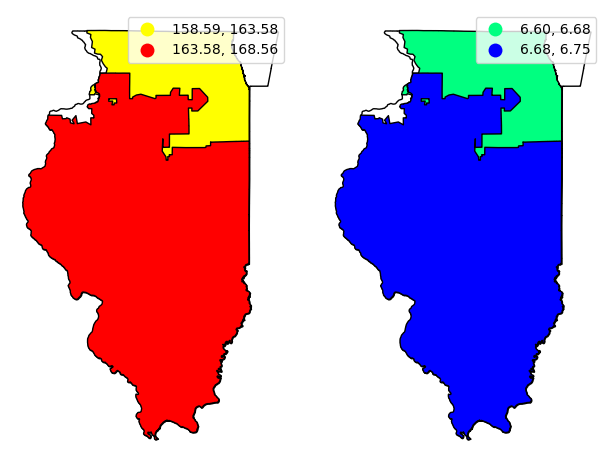

In [26]:
k = len(il_service_simple)
fig, ax = plt.subplots(1,2)
il_counties.dissolve('STATEFP10').plot(ax=ax[0],facecolor='w',edgecolor='k')
il_counties.dissolve('STATEFP10').plot(ax=ax[1],facecolor='w',edgecolor='k')
il_service_simple.plot(ax=ax[0], 
                column='AVG_GHI',
                scheme='equal_interval',
                k=k,
                cmap='autumn_r',
                legend=True,
                # alpha=0.5,
                edgecolor='k')
il_service_simple.plot(ax=ax[1], 
                column='AVG_WIND_80M',
                cmap='winter_r',
                scheme='equal_interval',
                k=k,
                legend=True,
                # alpha=0.5,
                edgecolor='k')
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()